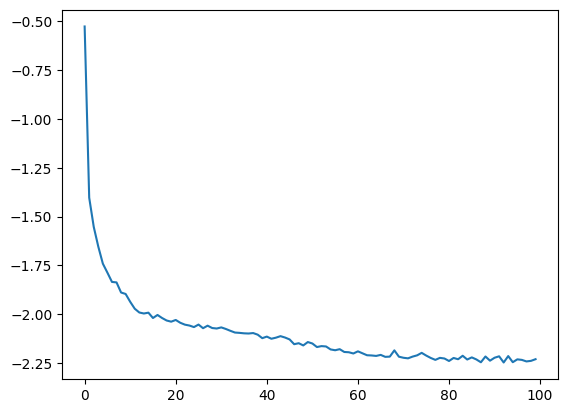

pearson 0.8794558013605644


FileNotFoundError: [Errno 2] No such file or directory: '../img/elife_subtle.png'

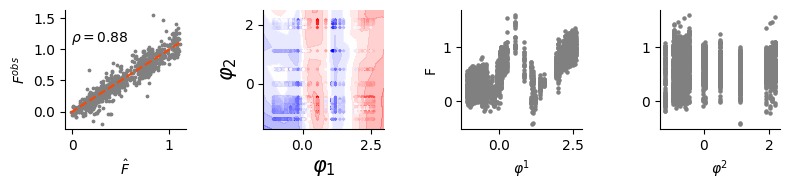

In [3]:
from dlim.model import DLIM
from dlim.utils import Data_model, train, spectral_init, compute_cor_scores
from numpy import mean, linspace, array, meshgrid, exp, diff, logical_and
from numpy.random import choice
from torch import tensor, float32 as tfloat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

data = Data_model("./data/elife/elife_data_subtle_env.csv", 2, sep="@")

train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.8), replace=False)
train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_id], :]

model = DLIM(data.nb_val, hid=32, nb_layer=1)

sim = "pearson"
model.spec_init_emb(train_data, data.mut_to_index, sim=sim, temp=1)

losses = train(model, train_data, lr=1e-3, nb_epoch=100, bsize=64, pen_emb=0)
fit_v, var, _ = model(val_data[:, :-1].long(), detach=True)
score = ((fit_v.flatten() - val_data[:, [-1]].flatten())**2).sum()

plt.plot(losses)
plt.show()

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
fit, var, _ = model(val_data[:, :-1].long(), detach=True)
ax.scatter(fit, val_data[:, [-1]], s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = r2_score(fit.flatten(), val_data[:, [-1]].flatten())
print(sim, score)
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")

fit, var, lat = model(data[:, :-1].long(), detach=True)
model.plot(bx, data=data, fontsize=15)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)

cx.scatter(lat[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")

plt.tight_layout()
plt.savefig("./img/elife_subtle.png", dpi=300, transparent=True)
plt.show()

## Add the pathway descrition


In [4]:
ENV_LIST = ['EC Batch 19_fitness', 'EC Batch 3_fitness', 'EC Batch 6_fitness',
       'EC Batch 13_fitness', 'EC Batch 18_fitness',
       'EC Batch 20_fitness', 'EC Batch 21_fitness',
       'EC Batch 23_fitness', 'EC 1BigBatch_fitness',
       '12 hr Ferm_fitness', '8 hr Ferm_fitness', '18 hr Ferm_fitness',
       '0.5% DMSO_fitness', '8.5 μM GdA (B1)_fitness',
       'Baffle, 1.4% Gluc_fitness', 'Baffle (B8)_fitness',
       'Baffle, 1.6% Gluc_fitness', 'Baffle, 1.7% Gluc_fitness',
       'Baffle (B9)_fitness', '1.4% Gluc_fitness', '1.8% Gluc_fitness',
       '2 μg/ml Flu_fitness', '1% Raf_fitness', '0.5% Raf_fitness',
       '1% Gly_fitness']
ENV_SHORT_LIST = ['EC', 'EC', 'EC', 'EC',
       'EC', 'EC', 'EC', 'EC',
       'EC', 'Ferm', 'Ferm', 'Ferm',
       '0.5% DMSO', '8.5 μM GdA (B1)', 'Gluc', 'Baffle',
       'Gluc', 'Gluc', 'Baffle',
       'Gluc', 'Gluc', '2 μg/ml Flu', 'Raf', 'Raf',
       '1% Gly']
dic_env_dict = dict([(name, env_short) for name, env_short in zip(ENV_LIST, ENV_SHORT_LIST)])
list_env = ['EC', 'Ferm', 'Gluc', 'Raf', 'Baffle']

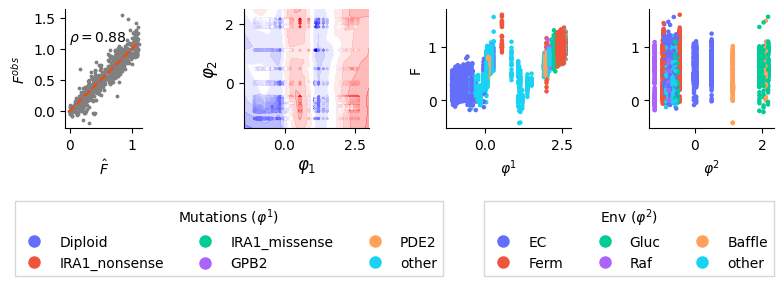

In [8]:
import plotly.express as px 
import pandas as pd 
color_l = px.colors.qualitative.Plotly
dic_env_dict = dict([(name, env_short) for name, env_short in zip(ENV_LIST, ENV_SHORT_LIST)])

data_org = pd.read_csv("./data/elife/elife_data_subtle_env.csv", sep = '@', header = None)
data_org.columns = ['barcode', 'env', 'fitness']
data_raw = pd.read_csv('./data/elife/elife-61271-fig2-data1-v2.csv')
data_raw.head()
data_raw_selec = data_raw[['barcode', 'gene', 'type', 'mutation_type']]
data_merge = data_org.merge(data_raw_selec, how = 'left', on = 'barcode')
list_ = ['Diploid', 'IRA1_nonsense', 'IRA1_missense', 'GPB2', 'PDE2']
data_merge['mutation_type_s'] = data_merge['mutation_type'].apply(lambda x: x if x in list_ else 'other')
data_merge['env_s'] = data_merge['env'].map(dic_env_dict)
data_merge['env_type_s'] = data_merge['env_s'].apply(lambda x: x if x in list_env else 'other')
# data_merge['mutation_type_s'] = data_merge['mutation_type'].str.split('_',n = 1, expand =True)[0]
# data_merge['mutation_type_short'] = data_merge['mutation_type_s'].str.split(' +',n = 1, expand =True)[0]
dic = dict([(mut, id) for id, mut in enumerate(data_merge.mutation_type_s.unique())])
list_mut_all = list_ + ['other']
dic_color = dict([(mut, color_l[id]) for id, mut in enumerate(list_mut_all)])
list_env_all = list_env + ['other']
dic_color_env = dict([(env, color_l[id]) for id, env in enumerate(list_env_all)])
fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
ax.scatter(fit_v, val_data[:, [-1]].detach(), s=3, c="grey")
x = linspace(min(fit_v), max(fit_v), num=100)
y = linspace(min(fit_v), max(fit_v), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = r2_score(fit_v.flatten(), val_data[:, [-1]].flatten())
ax.text(fit_v.min(), fit_v.max(), f"$\\rho={score:.2f}$")

model.plot(bx, data)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)
ax.set_aspect(1)
# bx.set_aspect(1)

# Plot the a00verage curve
fit_a, var_a, lat_a = model(data[:, :-1].long(), detach=True)
scatter = cx.scatter(lat_a[:, 0], data[:, -1], s=5, c=data_merge['mutation_type_s'].map(dic_color))
dx.scatter(lat_a[:, 1], data[:, -1], s=5, c=data_merge['env_type_s'].map(dic_color_env))
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")
        #    loc='upper center', bbox_to_anchor=(-1.0, -0.0), fancybox=True, shadow=True, ncol=6)

# Adding a legend
handles = []
for item in dic_color:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dic_color[item], markersize=10, label=item))

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.3, -0.0), fancybox=False, shadow=False, ncol=3, title = f'Mutations ($\\varphi^{1})$')

handles = []
for item in dic_color_env:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dic_color_env[item], markersize=10, label=item))

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.8, -0.0), fancybox=False, shadow=False, ncol=3, title = f'Env ($\\varphi^{2})$')
plt.tight_layout()
plt.savefig("./img/elife_subtle.png", dpi=300, transparent=True)
plt.show()

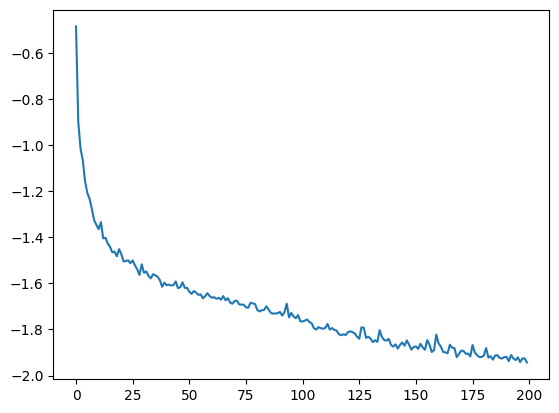

pearson 0.8721732989996994


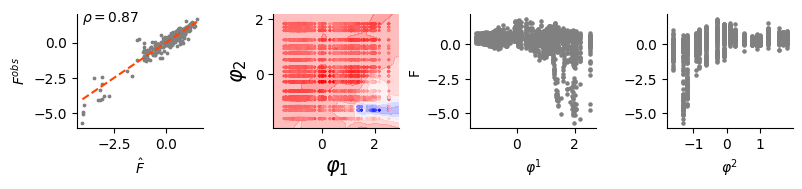

In [19]:
from dlim.model import DLIM
from dlim.utils import Data_model, train, spectral_init, compute_cor_scores
from numpy import mean, linspace, array, meshgrid, exp, diff, logical_and
from numpy.random import choice
from torch import tensor, float32 as tfloat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

data = Data_model("./data/elife/elife_data_strong_env.csv", 2, sep="@")

train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.8), replace=False)
train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_id], :]

model = DLIM(data.nb_val, hid=128, nb_layer=2)

sim = "pearson"
model.spec_init_emb(train_data, data.mut_to_index, sim=sim, temp=1)

losses = train(model, train_data, lr=1e-3, nb_epoch=200, bsize=128, wei_dec=1e-3, pen_emb=0)
fit_v, var, _ = model(val_data[:, :-1].long(), detach=True)

plt.plot(losses)
plt.show()

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
fit, var, _ = model(val_data[:, :-1].long(), detach=True)
ax.scatter(fit, val_data[:, [-1]], s=3, c="grey")
x = linspace(min(fit), max(fit), num=100)
y = linspace(min(fit), max(fit), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = r2_score(fit.flatten(), val_data[:, [-1]].flatten())
print(sim, score)
ax.text(fit.min(), fit.max(), f"$\\rho={score:.2f}$")

fit, var, lat = model(data[:, :-1].long(), detach=True)
model.plot(bx, data=data, fontsize=15)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)

cx.scatter(lat[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")

plt.tight_layout()
plt.savefig("./img/elife_strong.png", dpi=300, transparent=True)
plt.show()

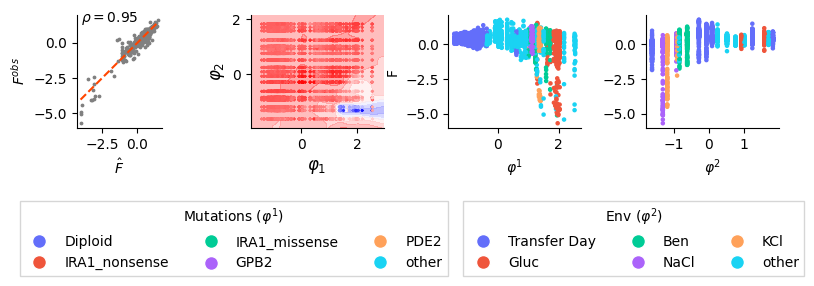

In [21]:
import plotly.express as px 
color_l = px.colors.qualitative.Plotly
ENV_LIST = ['22 hr Ferm_fitness', '1 Day_fitness', '3 Day_fitness',
       '4 Day_fitness', '5 Day_fitness', '6 Day_fitness', '7 Day_fitness',
       'Baffle, 1.8% Gluc_fitness', 'Baffle, 2.5% Gluc_fitness',
       'Baffle, 0.4 μg/ml Ben_fitness', 'Baffle, 2 μg/ml Ben_fitness',
       '0.2 M NaCl_fitness', '0.5 M NaCl_fitness', '0.2 M KCl_fitness',
       '0.5 M KCl_fitness', '8.5 μM GdA (B9)_fitness',
       '17 μM GdA_fitness', '0.5 μg/ml Flu_fitness', '1% EtOH_fitness',
       '1.5% Suc, 1% Raf_fitness']
ENV_SHORT_LIST = ['Ferm', 'Transfer Day', 'Transfer Day',
       'Transfer Day','Transfer Day', 'Transfer Day', 'Transfer Day',
       'Gluc', 'Gluc',
       'Ben', 'Ben',
       'NaCl', 'NaCl', 'KCl',
       'KCl', '8.5 μM GdA (B9)_fitness',
       '17 μM GdA_fitness', '0.5 μg/ml Flu_fitness', '1% EtOH_fitness',
       '1.5% Suc, 1% Raf_fitness']
dic_env_dict = dict([(name, env_short) for name, env_short in zip(ENV_LIST, ENV_SHORT_LIST)])

data_org = pd.read_csv("./data/elife/elife_data_strong_env.csv", sep = '@', header = None)
data_org.columns = ['barcode', 'env', 'fitness']
data_raw = pd.read_csv('./data/elife/elife-61271-fig2-data1-v2.csv')
data_raw.head()
data_raw_selec = data_raw[['barcode', 'gene', 'type', 'mutation_type']]
data_merge = data_org.merge(data_raw_selec, how = 'left', on = 'barcode')
list_ = ['Diploid', 'IRA1_nonsense', 'IRA1_missense', 'GPB2', 'PDE2']
list_env = ['Transfer Day', 'Gluc', 'Ben', 'NaCl', 'KCl']
data_merge['mutation_type_s'] = data_merge['mutation_type'].apply(lambda x: x if x in list_ else 'other')
data_merge['env_s'] = data_merge['env'].map(dic_env_dict)
data_merge['env_type_s'] = data_merge['env_s'].apply(lambda x: x if x in list_env else 'other')
# data_merge['mutation_type_s'] = data_merge['mutation_type'].str.split('_',n = 1, expand =True)[0]
# data_merge['mutation_type_short'] = data_merge['mutation_type_s'].str.split(' +',n = 1, expand =True)[0]
dic = dict([(mut, id) for id, mut in enumerate(data_merge.mutation_type_s.unique())])
list_mut_all = list_ + ['other']
dic_color = dict([(mut, color_l[id]) for id, mut in enumerate(list_mut_all)])
list_env_all = list_env + ['other']
dic_color_env = dict([(env, color_l[id]) for id, env in enumerate(list_env_all)])
fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
ax.scatter(fit_v, val_data[:, [-1]].detach(), s=3, c="grey")
x = linspace(min(fit_v), max(fit_v), num=100)
y = linspace(min(fit_v), max(fit_v), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
# score = r2_score(fit.flatten(), val_data[:, [-1]].flatten())
score = pearsonr(fit_v.flatten(), val_data[:, [-1]].flatten())[0]
ax.text(fit_v.min(), fit_v.max(), f"$\\rho={score:.2f}$")

model.plot(bx, data)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)
ax.set_aspect(1)
# bx.set_aspect(1)

# Plot the a00verage curve
fit_a, var_a, lat_a = model(data[:, :-1].long(), detach=True)
scatter = cx.scatter(lat_a[:, 0], data[:, -1], s=5, c=data_merge['mutation_type_s'].map(dic_color))
dx.scatter(lat_a[:, 1], data[:, -1], s=5, c=data_merge['env_type_s'].map(dic_color_env))
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")

handles = []
for item in dic_color:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dic_color[item], markersize=10, label=item))

fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.3, -0.0), fancybox=False, shadow=False, ncol=3, title = f'Mutations ($\\varphi^{1})$')

handles = []
for item in dic_color_env:
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=dic_color_env[item], markersize=10, label=item))

lgd = fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.8, -0.0), fancybox=False, shadow=False, ncol=3, title = f'Env ($\\varphi^{2})$')
plt.tight_layout()
# plt.savefig("./img/elife_strong.png", dpi=300, transparent=True, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()